In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import matplotlib.style as style
import plotly.graph_objects as go
import plotly.express as px
sns.set_theme(style='whitegrid')

In [2]:
# personal computer
df = pd.read_csv("~/Nextcloud/linkedin_recruiter/inputs/model_input.csv", low_memory=False)
# for windows
# df = pd.read_csv("N:/johnson/linkedin_recruiter/inputs/model_input.csv")

In [3]:
df.columns

Index(['country_orig', 'country_dest', 'flow', 'users_orig', 'users_dest',
       'iso3_orig', 'pop_orig', 'gdp_orig', 'hdi_orig', 'iso3_dest',
       'pop_dest', 'gdp_dest', 'hdi_dest', 'query_date', 'region_orig',
       'subregion_orig', 'midregion_orig', 'region_dest', 'subregion_dest',
       'midregion_dest', 'prop_orig', 'prop_dest', 'area_orig', 'area_dest',
       'internet_orig', 'internet_dest', 'eea_orig', 'eu_orig',
       'eurozone_orig', 'schengen_orig', 'eea_dest', 'eu_dest',
       'eurozone_dest', 'schengen_dest', 'dist_biggest_cities',
       'dist_pop_weighted', 'dist_unweighted', 'contig', 'comlang_ethno',
       'colony', 'comcol', 'curcol', 'col45', 'smctry', 'col', 'csl', 'cnl',
       'prox1', 'prox2', 'comp', 'net_flow', 'net_rate_100', 'bin_hdi_orig',
       'bin_hdi_dest', 'bin_gdp_orig', 'bin_gdp_dest'],
      dtype='object')

In [46]:
ID_COLS = ['country_orig', 'country_dest', 'query_date']
DIST_COLS = [x for x in df.columns if 'dist' in x]
BINARY = ['contig', 'comlang_ethno', 'colony', 'comcol', 'curcol', 'col45', 'col']
eu = df.loc[(df['eu_orig'] == 1) & (df['eu_dest'] == 1)]
square_df = df.loc[df['comp'] == 1]
square_eu = df.loc[(df['eu_orig'] == 1) & (df['eu_dest'] == 1) & (df['comp'] == 1)]

### Number of country pairs

In [5]:
def get_num_pairs(df, col_name):
    return df.groupby('query_date')[['iso3_orig', 'iso3_dest']].count().drop(
        'iso3_dest', axis=1).rename(columns={'iso3_orig': col_name})
pd.concat(
    [get_num_pairs(df, 'num pairs'),
    get_num_pairs(square_df, 'num reciprocal pairs'),
    get_num_pairs(eu, 'num EU pairs'),
    get_num_pairs(square_eu, 'num EU reciprocal pairs')], axis=1)

num pairs  num reciprocal pairs  num EU pairs  \
query_date                                                  
2020-07-25       4582                  1524           339   
2020-10-08       4520                  1450           333   
2020-10-20       4704                  1526           327   
2020-11-04       4738                  1478           313   
2020-11-19       4694                  1474           310   
2020-12-01       4682                  1474           309   
2020-12-16       4662                  1452           315   
2020-12-31       4599                  1422           302   
2021-01-12       4516                  1454           309   
2021-01-27       4645                  1420           307   
2021-02-08       2593                  1196           178   
2021-02-23       4618                  1426           314   

            num EU reciprocal pairs  
query_date                           
2020-07-25                      162  
2020-10-08                      160  
2020-10-20                      160  
2020-11-04                      138  
2020-11-19                      136  
2020-12-01                      134  
2020-12-16                      140  
2020-12-31                      126  
2021-01-12                      140  
2021-01-27                      132  
2021-02-08                      110  
2021-02-23                      134

### Which countries are completely dropped when only keeping the reciprocal pairs?

In [8]:
set(df.country_dest) - set(square_df.country_dest)

{'Iceland', 'Monaco', 'Mongolia', 'Nauru'}

### Which origin countries show up most often?
#### We know only the top 75 origin countries are returned, so check how often certain origin locations appear in the data

In [9]:
df.assign(
    counts=df.groupby(['country_orig', 'query_date'])['country_orig'].transform('count')
).pivot_table('counts', 'country_orig', 'query_date').sort_values(by='2020-07-25', ascending=False).head(20)

query_date            2020-07-25  2020-10-08  2020-10-20  2020-11-04  \
country_orig                                                           
United States              172.0       174.0       182.0       185.0   
United Kingdom             170.0       172.0       179.0       182.0   
France                     167.0       163.0       165.0       170.0   
India                      158.0       157.0       164.0       164.0   
Canada                     141.0       140.0       143.0       144.0   
Germany                    137.0       142.0       147.0       148.0   
United Arab Emirates       124.0       117.0       120.0       116.0   
Spain                      120.0       115.0       120.0       125.0   
Italy                      107.0       116.0       121.0       122.0   
Netherlands                 99.0       101.0       102.0        95.0   
Australia                   87.0        79.0        84.0        85.0   
China                       86.0        81.0        80.0        77.0   
Egypt                       84.0        80.0        82.0        81.0   
Turkey                      84.0        83.0        81.0        81.0   
South Africa                78.0        77.0        83.0        82.0   
Nigeria                     73.0        67.0        77.0        82.0   
Pakistan                    69.0        62.0        60.0        58.0   
Saudi Arabia                63.0        65.0        68.0        69.0   
Brazil                      63.0        70.0        72.0        71.0   
Malaysia                    62.0        58.0        61.0        65.0   

query_date            2020-11-19  2020-12-01  2020-12-16  2020-12-31  \
country_orig                                                           
United States              184.0       185.0       184.0       184.0   
United Kingdom             181.0       182.0       180.0       180.0   
France                     169.0       167.0       167.0       166.0   
India                      161.0       163.0       160.0       160.0   
Canada                     145.0       150.0       142.0       154.0   
Germany                    144.0       138.0       141.0       140.0   
United Arab Emirates       118.0       118.0       114.0       112.0   
Spain                      122.0       121.0       125.0       121.0   
Italy                      121.0       121.0       121.0       121.0   
Netherlands                 91.0        89.0        93.0        91.0   
Australia                   82.0        79.0        83.0        76.0   
China                       77.0        78.0        78.0        74.0   
Egypt                       79.0        74.0        75.0        72.0   
Turkey                      81.0        80.0        82.0        81.0   
South Africa                84.0        85.0        89.0        80.0   
Nigeria                     78.0        75.0        75.0        73.0   
Pakistan                    59.0        60.0        59.0        60.0   
Saudi Arabia                68.0        67.0        67.0        67.0   
Brazil                      70.0        72.0        72.0        72.0   
Malaysia                    63.0        63.0        60.0        59.0   

query_date            2021-01-12  2021-01-27  2021-02-08  2021-02-23  
country_orig                                                          
United States              180.0       185.0        41.0       185.0  
United Kingdom             176.0       182.0        41.0       182.0  
France                     164.0       167.0        40.0       166.0  
India                      159.0       163.0        41.0       160.0  
Canada                     148.0       157.0        30.0       154.0  
Germany                    137.0       145.0        41.0       146.0  
United Arab Emirates       108.0       113.0        26.0       113.0  
Spain                      115.0       121.0        33.0       123.0  
Italy                      116.0       119.0        34.0       119.0  
Netherlands                 86.0        95.0     

### Within the EU:
#### All 27 countries, except Malta & Czech Republic are present at least once in each collection

In [26]:
square_eu.assign(
    counts=square_eu.groupby(['country_orig', 'query_date'])['country_orig'].transform('count')
).pivot_table('counts', 'country_orig', 'query_date').sort_values(by='2020-07-25', ascending=False)

query_date      2020-07-25  2020-10-08  2020-10-20  2020-11-04  2020-11-19  \
country_orig                                                                 
Romania               15.0        14.0        14.0        13.0        13.0   
Poland                12.0        11.0        11.0         8.0         8.0   
France                10.0        10.0        10.0        10.0        10.0   
Spain                 10.0        10.0        10.0        10.0         9.0   
Netherlands           10.0        12.0        11.0        10.0         9.0   
Italy                 10.0        10.0        10.0         9.0         9.0   
Sweden                 9.0         9.0         8.0         9.0         8.0   
Germany                9.0        10.0         9.0         9.0         9.0   
Belgium                8.0         9.0         9.0         9.0         8.0   
Ireland                8.0         8.0         8.0         8.0         8.0   
Czech Republic         8.0         9.0         8.0         NaN         NaN   
Hungary                7.0         7.0         6.0         4.0         3.0   
Greece                 6.0         6.0         7.0         4.0         5.0   
Austria                6.0         6.0         7.0         5.0         5.0   
Denmark                4.0         3.0         2.0         3.0         3.0   
Portugal               4.0         5.0         5.0         5.0         5.0   
Bulgaria               4.0         2.0         3.0         3.0         3.0   
Finland                3.0         2.0         2.0         2.0         3.0   
Estonia                3.0         3.0         3.0         3.0         3.0   
Latvia                 3.0         2.0         2.0         2.0         2.0   
Slovakia               3.0         3.0         3.0         2.0         2.0   
Lithuania              2.0         2.0         2.0         2.0         2.0   
Luxembourg             2.0         2.0         3.0         2.0         3.0   
Cyprus                 2.0         1.0         2.0         2.0         2.0   
Croatia                2.0         2.0         3.0         2.0         2.0   
Slovenia               2.0         2.0         2.0         2.0         2.0   
Malta                  NaN         NaN         NaN         NaN         NaN   

query_date      2020-12-01  2020-12-16  2020-12-31  2021-01-12  2021-01-27  \
country_orig                                                                 
Romania               14.0        13.0        12.0        12.0        11.0   
Poland                10.0         9.0         9.0        10.0         9.0   
France                10.0        11.0         9.0        10.0         9.0   
Spain                  9.0        10.0         9.0         9.0         9.0   
Netherlands            9.0         9.0         9.0        11.0        10.0   
Italy                  9.0        10.0         9.0         9.0        10.0   
Sweden                 7.0         7.0         6.0         6.0         8.0   
Germany                8.0         8.0         7.0        10.0        10.0   
Belgium                7.0         9.0         7.0         8.0         7.0   
Ireland                8.0         8.0         7.0         8.0         7.0   
Czech Republic         NaN         NaN         NaN         NaN         NaN   
Hungary                4.0         4.0         3.0         5.0         4.0   
Greece                 5.0         5.0         3.0         5.0         4.0   
Austria                5.0         5.0         6.0         5.0         6.0   
Denmark                2.0         2.0         2.0         3.0         2.0   
Portugal               4.0         7.0         6.0         6.0         5.0   
Bulgaria               3.0         3.0         4.0         3.0         3.0   
Finland                2.0         2.0         2.0         1.0         2.0   
Estonia                3.0         3.0         3.0         3.0         3.0   
Latvia                 2.0         2.0         2.0         2.0         2.0   
Slovakia             

## Most frequently appearing origin countries are not also those with the most linkedin users

In [28]:
def compare_top_20(df):
    top_20 = df.assign(
        counts=df.groupby(['country_orig', 'query_date'])['country_orig'].transform('count')
    ).pivot_table('counts', 'country_orig', 'query_date').sort_values(
        by='2020-07-25', ascending=False).head(20).index.values
    top_users = df[['users_orig', 'country_orig']].drop_duplicates(
        subset='country_orig').sort_values(by='users_orig').tail(20)['country_orig']
    print(f'In top 20 origin country, but not most users:\n{set(top_20) - set(top_users)}\n''')
    print(f'In top 20 by number of users, but not in frequency as country of origin:\n{set(top_users) - set(top_20)}')

In [29]:
compare_top_20(df)

In top 20 origin country, but not most users:
{'United Arab Emirates', 'Saudi Arabia', 'Pakistan', 'Malaysia', 'Nigeria', 'Egypt'}

In top 20 by number of users, but not in frequency as country of origin:
{'Argentina', 'Philippines', 'Russia', 'Colombia', 'Mexico', 'Indonesia'}


### Within EU?

In [30]:
compare_top_20(eu)

In top 20 origin country, but not most users:
{'Latvia'}

In top 20 by number of users, but not in frequency as country of origin:
{'Croatia'}


# From here on out, only keep the reciprocal pairs

## Distance

#### missing values?

In [61]:
# nothing missing from EU
square_eu[DIST_COLS].isnull().values.any()

False

In [63]:
# missing values in global dataset
square_df[square_df[DIST_COLS].isnull().any(axis=1)][['country_orig', 'country_dest']].drop_duplicates().sort_values(by='country_orig').reset_index(drop=True)

country_orig              country_dest
0                Afghanistan               South Sudan
1                      Aruba                   Curacao
2                    Burundi               South Sudan
3   Central African Republic               South Sudan
4                       Chad               South Sudan
5                    Curacao                  Suriname
6                    Curacao                     Aruba
7                   Ethiopia               South Sudan
8                    Liberia               South Sudan
9               Sierra Leone               South Sudan
10                   Somalia               South Sudan
11               South Sudan               Afghanistan
12               South Sudan                      Chad
13               South Sudan              Sierra Leone
14               South Sudan                    Uganda
15               South Sudan                  Ethiopia
16               South Sudan                   Liberia
17               South Sudan  Central African Republic
18               South Sudan                     Syria
19               South Sudan                     Sudan
20               South Sudan                   Somalia
21               South Sudan                     Yemen
22               South Sudan                   Burundi
23                     Sudan               South Sudan
24                  Suriname                   Curacao
25                     Syria               South Sudan
26                    Uganda               South Sudan
27                     Yemen               South Sudan

### area is a bit related

In [23]:
def pairplot(df, suffix, name):
    plt.figure(figsize=(10,10))
    g = sns.jointplot(data=square_eu, x=np.log(square_eu[f"area_{suffix}"]), y=np.log(square_eu["flow"]))
    g.set_axis_labels(f'{name} Area (sq km)', 'Flow')
    plt.savefig(f"/Users/scharlottej13/Nextcloud/linkedin_recruiter/outputs/eu_flow_area_{suffix}.png", dpi=300)

<Figure size 720x720 with 0 Axes>

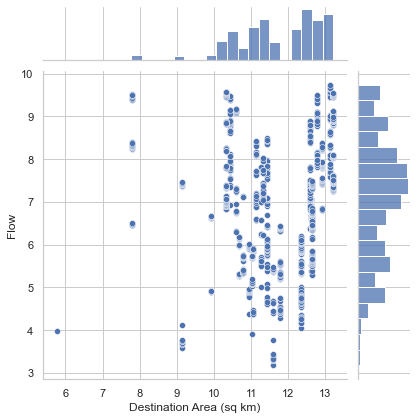

In [25]:
pairplot(square_eu, 'dest', 'Destination')

In [116]:
def ttest(df, grp_var, date='2020-10-08'):
    a = df[(df[f'{grp_var}'] == 1) & (df['query_date'] == date)]['flow'].values
    b = df[(df[f'{grp_var}'] == 0) & (df['query_date'] == date)]['flow'].values
    print(f'T test for {grp_var}')
    print(stats.ttest_ind(a, b, equal_var=False))
    cm = sms.CompareMeans(sms.DescrStatsW(a), sms.DescrStatsW(b))
    print(cm.tconfint_diff(usevar='unequal'))

### does it matter if a country shares a border?

In [117]:
ttest(square_df, grp_var='comcol')

T test for comcol
Ttest_indResult(statistic=-4.335379623621829, pvalue=1.657205521917695e-05)
(-2679.1464258746078, -1009.0326212565402)


In [122]:
# square_df['comcol_categ'] = square_df['comcol'].replace(0, 'No').replace(1, 'Yes')
px.scatter(
    square_df, x=np.log(square_df['gdp_dest']), y=np.log(square_df['flow']),
    hover_data=['country_orig', 'country_dest'],
    size='area_orig', color='comcol',
    title='Global Migration Aspirations vs. Destination GDP',
    labels={'y': 'Migration Aspirations (log(number))',
            'x': 'log(GDP)', 'colony': 'Colony',
            'country_dest': 'Destination', 'country_orig': 'Origin'}
)

# Comparison with GWP

In [59]:
# merge w/ gallup
gwp = pd.read_csv("/Users/scharlottej13/Nextcloud/linkedin_recruiter/inputs/GWP/pnmi.csv")
gwp[['PNMI', 'Brain', 'Youth']] = gwp[['PNMI', 'Brain', 'Youth']].apply(
    lambda x: (x.str.strip('%')).astype(float)/100)
gwp.head()

country  PNMI  Brain  Youth
0  Afghanistan -0.26    NaN  -0.33
1      Albania -0.32  -0.50  -0.25
2      Algeria -0.31  -0.40  -0.44
3    Argentina -0.02   0.01  -0.08
4      Armenia  0.04  -0.24   0.37

In [70]:
gwp_comp = gwp.merge(
    square_df[['country_orig', 'net_rate_100', 'query_date', 'eu_orig', 'pop_orig', 'users_orig']].drop_duplicates(),
    left_on='country', right_on='country_orig'
)
gwp_comp['eu_orig'] = gwp_comp['eu_orig'].map({1: 'yes', 0: 'no'})
gwp_comp.head()

country  PNMI  Brain  Youth country_orig  net_rate_100  query_date  \
0  Afghanistan -0.26    NaN  -0.33  Afghanistan      0.090383  2020-11-04   
1  Afghanistan -0.26    NaN  -0.33  Afghanistan      0.097651  2020-11-19   
2  Afghanistan -0.26    NaN  -0.33  Afghanistan      0.150926  2020-10-08   
3  Afghanistan -0.26    NaN  -0.33  Afghanistan      0.080586  2020-10-20   
4  Afghanistan -0.26    NaN  -0.33  Afghanistan      0.092386  2020-12-01   

  eu_orig    pop_orig  users_orig  
0      no  36296000.0      242303  
1      no  36296000.0      238605  
2      no  36296000.0      237865  
3      no  36296000.0      240736  
4      no  36296000.0      239214

In [65]:
gwp_comp[['PNMI', 'net_rate_100']].describe()
# like orders of magnitude larger?
# b/c of population denominator vs. LinkedIn Users?
# but if you use population as the denominator for LI data then it'd be way to small, right?

PNMI  net_rate_100
count  11449.000000  11449.000000
mean       0.071432      0.806198
std        0.547284      3.790876
min       -0.700000     -7.809028
25%       -0.240000     -0.450982
50%       -0.110000     -0.077204
75%        0.230000      0.863506
max        2.310000     89.423467

In [62]:
px.scatter(
    gwp_comp, x=np.log(gwp_comp.Youth),
    y=np.log(gwp_comp.net_rate_100),
    hover_data=['country'], color='eu_orig',
    title='Net Migration per 100 (log transformed)',
    labels={'x': 'GWP Youth', 'y': 'LinkedIn'}
)

/Users/scharlottej13/anaconda3/envs/linkedin_recruiter/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning:

divide by zero encountered in log

/Users/scharlottej13/anaconda3/envs/linkedin_recruiter/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning:

invalid value encountered in log



In [75]:
fig = px.scatter(
    gwp_comp, x=np.log(gwp_comp.PNMI),
    y=np.log(gwp_comp.net_rate_100),
    hover_data=['country'], color=np.log(gwp_comp['users_orig']),
    title='Net Migration per 100 (log transformed)',
    labels={'x': 'GWP PNMI', 'y': 'LinkedIn'}
)
fig.update_xaxes(range=[-8.2,4.5])
fig.update_yaxes(range=[-8.2,4.5])
# fig.add_shape(type="line",
#     x0=4, y0=0, x1=6, y1=2,
#     line=dict(
#         color="MediumPurple",
#         width=4,
#         dash="dot"))
fig.show()

In [63]:
px.scatter(
    gwp_comp, x='Youth', y='net_rate_100',
    hover_data=['country'], color='eu_orig',
    title='Net Migration per 100',
    labels={'Youth': 'GWP Youth', 'net_rate_100': 'LinkedIn'})